In [1]:
import os 
import glob
import tarfile
import shutil
import random

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import imageio

from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [2]:
# get pairs data

with open("/kaggle/input/lfwpeople/pairsDevTrain.txt", "r") as f:
    pairs_train = f.read()

with open("/kaggle/input/lfwpeople/pairsDevTest.txt", "r") as f:
    pairs_test = f.read()

In [3]:
with tarfile.open("/kaggle/input/lfwpeople/lfw-funneled.tgz", "r") as tar:
    for member in tar.getmembers():
        tar.extract(member, "data")

In [4]:
# only keep images with more than three samples for training
path =  "/kaggle/working/data/lfw_funneled"

# find only subdirectories
people = glob.glob(path+"/*/")

counter = 0

# delete all directories with less than 3 images
for p in people:
    if len(os.listdir(p)) < 5:
        shutil.rmtree(p)
        counter += 1

# reset people
print(f"{counter} of {len(people)} directories had to be removed because of too few samples!")
people = glob.glob(path+"/*/")

5326 of 5749 directories had to be removed because of too few samples!


In [5]:
random.seed(42)
people = random.sample(people, int(0.1 * len(people)))

In [6]:
image_shape_map = {}
for p in people:
    for img_file in os.listdir(p):
        img = imageio.v2.imread(os.path.join(p, img_file))
        img_shape=np.array(img).shape

if img_shape not in image_shape_map.keys():
    image_shape_map[img_shape] = 1
else:
    image_shape_map[img_shape] +=1

print(len(image_shape_map.keys()) == 1)
print("All the images are of the same size!!")


True
All the images are of the same size!!


In [7]:
image_shape_map

{(250, 250, 3): 1}

In [8]:
pair_mapping = {}

# set index counter
counter = 0


for ind, p in enumerate(people):
   
    pair_mapping[ind] = []

    # loop through every file in the directory and map the index of the files to the internal_counter
    # note: we skip the first file, because this is already the key of the mapping
    for file in os.listdir(p):
        
        pair_mapping[ind].append(counter)
        counter += 1
    

In [9]:
len_data = 0

for p in people:
    len_data += len(os.listdir(p))
    
print("There are overall %s face images!" %len_data)

There are overall 551 face images!


In [10]:
len_of_samples = [len(xs) for xs in pair_mapping.values()]


In [11]:
# load all images into torch tensor

data = torch.zeros((len_data,3,250,250))

index = 0

# loop through all images and fill  the data array 
for p in people:
    for file in os.listdir(p):
        data[index] = torchvision.io.read_image(os.path.join(p, file)) / 255.
        index += 1

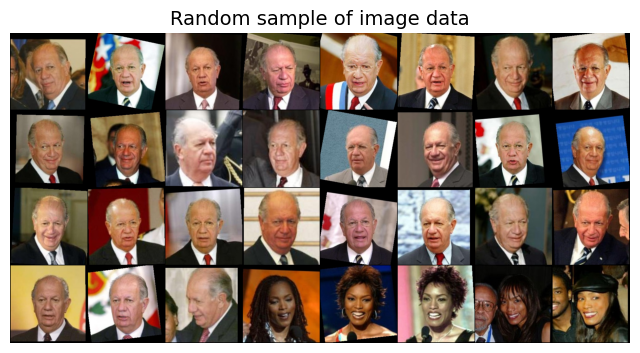

In [12]:
images =  data[:32]
grid = make_grid(images)
grid = grid.permute(1,2,0)
    

fig, ax = plt.subplots(figsize=(8,18))
ax.imshow(grid)

ax.axis('off')
plt.title("Random sample of image data", fontsize=14)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


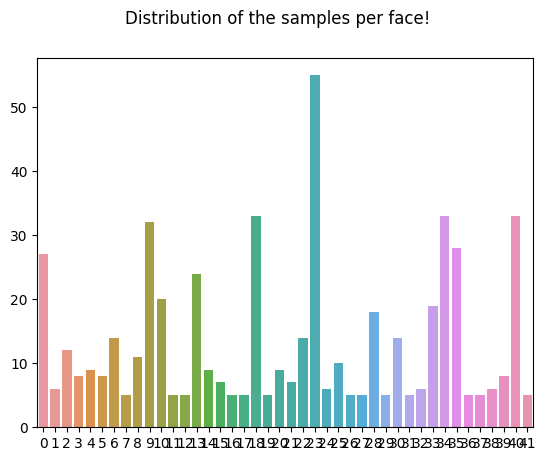

In [13]:
sns.barplot(y=len_of_samples, x=list(pair_mapping.keys()))
plt.suptitle("Distribution of the samples per face!")
plt.show()

In [14]:
print(f"There are {len(pair_mapping.keys())} unique faces!")


There are 42 unique faces!


In [15]:
# Create tuples of pairs 
positives = []
negatives = []

for key, indices in pair_mapping.items():
    # find positive matches
    # set base face which is the face all the other gets mapped to 
    indices = list(indices)
    
    # find indices that are not matching
    other_indices = set(range(len_data)).difference(set(indices))
    
    # loop through the matching indices
    for i, index in enumerate(indices):
        # build pairs of matching indices but just in one direction, so we have no unnecessary double pairs
        # we want to avoid pairs like that: (1,2), (2,1) ....
        for subindex in indices[i + 1:]:
            # form a tuple with the matching face and add it to the list 
            positives.append((index, subindex))
        
        # loop through all the other indices and build matches with the current index
        for subindex in other_indices:
            negatives.append((index, subindex))

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        # print(f'input : {x.shape}')
        x=self.block(x)
        # print(f'Output : {x.shape}')
        return x

class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, skip_res=True):
        super(ResBlock, self).__init__()
        self.skip_res=skip_res
        self.block = nn.Sequential(
            ConvBlock(in_channel, out_channel, kernel_size),
            ConvBlock(out_channel, out_channel, kernel_size),
            ConvBlock(out_channel, out_channel, kernel_size),
        )

    def forward(self, x):
        if self.skip_res: 
            return self.block(x)
        else:
            return x + self.block(x)
    

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.block = nn.Sequential(
            ResBlock(3, 64, 3),
            ResBlock(64, 64, 3, skip_res=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(64, 128, 3),
            ResBlock(128, 128, 3),
            ResBlock(128, 128, 3, skip_res=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(128, 256, 3),
            ResBlock(256, 256, 3, skip_res=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(256, 512, 3),
            ResBlock(512, 512, 3, skip_res=False),
        )
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)        
        self.fc = nn.Linear(115200, 128)

    def forward(self, x):
        x= self.block(x)
        x= self.pool(x)
        b, c, h, w = x.shape
        x= self.fc(x.reshape(b, -1))
        return x
        



In [17]:
def test():
    img = torch.randn((10, 3, 250, 250))
    model = ResNet()
    out = model(img)
    print(out.shape)

test()

torch.Size([10, 128])
